# 貓狗識別問題

OpenCV是開源的跨平台計算機視覺庫。  
pip install opencv-python

圖像是一個二維數組，每個元素大小是0-255之間  
cv2.imread()  
cv2.resize()  
cv2.cvtColor()  
cv2.imwrite()  
......  

Kaggle的貓狗數據集  
https://www.kaggle.com/competitions/dogs-vs-cats

In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [84]:
def readimg(startloc, endloc, filename):
    imgpath = 'D:\work\sample\sample'
    imgsize = 112
    dataset = np.zeros((2 * (endloc - startloc + 1), 3, imgsize, imgsize), dtype=np.uint8)
    labelset = np.zeros((2 * (endloc - startloc + 1)), dtype=np.int64)
    ii = 0

    # 定义轻量的数据增强 transform
    transform = transforms.Compose([
        #transforms.RandomHorizontalFlip(),    # 随机水平翻转
        # transforms.RandomRotation(10), # 小角度旋转
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor()
    ])

    for i in range(startloc, endloc + 1):
        # 读取猫和狗的图片
        imgcat = cv2.imread('%s/cat.%d.jpg' % (imgpath, i))
        imgdog = cv2.imread('%s/dog.%d.jpg' % (imgpath, i))

        # 检查是否读取成功
        if imgcat is None or imgdog is None:
            print(f"Image cat.{i}.jpg or dog.{i}.jpg not found in path {imgpath}.")
            continue
        
        # 调整图像大小
        imgcat = cv2.resize(imgcat, (imgsize, imgsize))
        imgdog = cv2.resize(imgdog, (imgsize, imgsize))
        
        # 转换为PIL格式以应用transform
        imgcat = Image.fromarray(cv2.cvtColor(imgcat, cv2.COLOR_BGR2RGB))
        imgdog = Image.fromarray(cv2.cvtColor(imgdog, cv2.COLOR_BGR2RGB))

        # 应用数据增强和归一化
        imgcat = transform(imgcat)
        imgdog = transform(imgdog)

        # 将数据范围从[0, 1]调整回[0, 255]
        imgcat = (imgcat * 255).byte().numpy()
        imgdog = (imgdog * 255).byte().numpy()

        # 将增强后的图像数据按 BGR 顺序存入 dataset
        dataset[2 * ii, 0, :, :] = imgcat[2, :, :]  # 红色通道
        dataset[2 * ii, 1, :, :] = imgcat[1, :, :]  # 绿色通道
        dataset[2 * ii, 2, :, :] = imgcat[0, :, :]  # 蓝色通道
        labelset[2 * ii] = 0  # 猫的标签为0

        dataset[2 * ii + 1, 0, :, :] = imgdog[2, :, :]
        dataset[2 * ii + 1, 1, :, :] = imgdog[1, :, :]
        dataset[2 * ii + 1, 2, :, :] = imgdog[0, :, :]
        labelset[2 * ii + 1] = 1  # 狗的标签为1
        
        ii += 1

    # 保存增强后的数据
    np.save(f'catdog_{filename}_set.npy', dataset)
    np.save(f'catdog_{filename}_label.npy', labelset)

In [85]:
readimg(0,69,'train')
readimg(70,99,'test')

In [86]:
import torch.nn.functional as F
class CDNet(nn.Module):
    def __init__(self):
        super(CDNet,self).__init__()
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,stride=2,padding=3),
                )
        self.maxpol = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1),
        )
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
        # )
        # self.conv1x1 = nn.Conv2d(128,256, 1,1)
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
        # )
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
        # )
        self.flatten = nn.Flatten()
        self.linenet=nn.Sequential(
                nn.Linear(1024,256),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(256,256),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(256,2),
                nn.Softmax(dim=1)
                )
    def forward(self,x):
        x1 = self.conv1(x)
        x1 = self.maxpol(x1)
        x2 = self.conv2(x1)
        x2 = self.maxpol(x2)
        # x3 = self.conv3(x2)
        # x4 = self.conv4(x3)
        # x4 = F.relu(x4+self.conv1x1(x3))
        # x5 = self.conv5(x2)
        x = self.flatten(x2)
        out=self.linenet(x)
        return out

In [87]:
#read x y
x=np.load('catdog_train_set.npy')/255.
x=torch.tensor(x,dtype=torch.float32)
print(x.shape)
y=np.load('catdog_train_label.npy')
y=torch.tensor(y,dtype=torch.long)
print(y.shape)

torch.Size([140, 3, 112, 112])
torch.Size([140])


In [88]:
# 加载验证数据
x_val = np.load('catdog_test_set.npy') / 255.0
x_val = torch.tensor(x_val, dtype=torch.float32)
x_val = x_val.cuda()
y_val = np.load('catdog_test_label.npy')
y_val = torch.tensor(y_val, dtype=torch.long)
y_val = y_val.cuda()

In [107]:
import os
import numpy as np
import random
seed = 3407
random.seed(seed)           # 设置Python内置的随机数生成器的种子
np.random.seed(seed)        # 设置NumPy随机数生成器的种子
torch.manual_seed(seed)     # 设置PyTorch CPU上随机数生成器的种子
torch.cuda.manual_seed(seed)# 设置PyTorch GPU上随机数生成器的种子
torch.cuda.manual_seed_all(seed)    # 设置所有可用GPU上的随机数生成器的种子
os.environ['PYTHONHASHSEED'] = str(seed)     # 设置环境变量PYTHONHASHSEED，以控制Python的哈希行为
# if deterministic:   # 如果需要确定性操作
#     torch.backends.cudnn.deterministic = True   # 设置CUDNN为确定性操作模式
#     torch.backends.cudnn.benchmark = False      # 禁用CUDNN自动优化模式，确保结果可复现

In [110]:
# 定义网络、优化器和损失函数
net = CDNet().cuda()
opt = optim. Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)
loss_func = nn.CrossEntropyLoss()

# 早停参数
patience = 10
best_val_loss = float('inf')
counter = 0

# 批次和图像尺寸
samplenum = 140
losslist = []

Epoch: 0, Training Loss: 0.6934
Epoch: 0, Validation Loss: 0.6930, Accuracy: 50.00%
Epoch: 50, Training Loss: 0.6669
Epoch: 50, Validation Loss: 0.6900, Accuracy: 55.00%
Epoch: 100, Training Loss: 0.4691
Epoch: 100, Validation Loss: 0.6450, Accuracy: 63.33%
Epoch: 150, Training Loss: 0.3514
Epoch: 150, Validation Loss: 0.6483, Accuracy: 65.00%
Epoch: 200, Training Loss: 0.3339
Epoch: 200, Validation Loss: 0.6559, Accuracy: 65.00%
Epoch: 250, Training Loss: 0.3447
Epoch: 250, Validation Loss: 0.6576, Accuracy: 65.00%
Epoch: 300, Training Loss: 0.3300
Epoch: 300, Validation Loss: 0.6604, Accuracy: 65.00%
Epoch: 350, Training Loss: 0.3299
Epoch: 350, Validation Loss: 0.6568, Accuracy: 65.00%
Epoch: 400, Training Loss: 0.3297
Epoch: 400, Validation Loss: 0.6601, Accuracy: 65.00%
Epoch: 450, Training Loss: 0.3297
Epoch: 450, Validation Loss: 0.6531, Accuracy: 65.00%
Epoch: 500, Training Loss: 0.3309
Epoch: 500, Validation Loss: 0.6432, Accuracy: 65.00%
Epoch: 550, Training Loss: 0.3293
Epoc

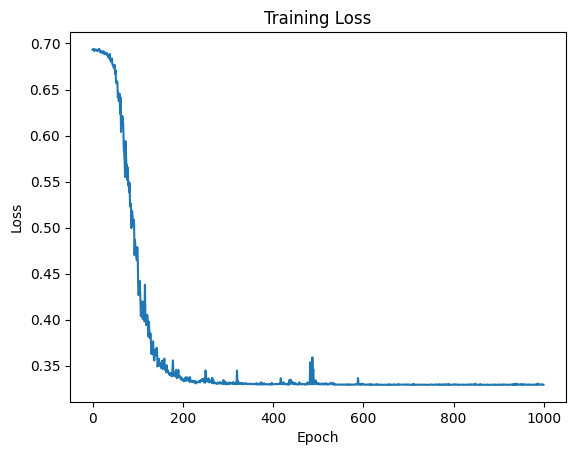

In [111]:
# 假设 x 和 y 是训练数据和标签
samplenum = len(x)
minibatch = 64
# 初始化早停参数
patience = 900  # 耐心值
min_delta = 1e-4  # 最小损失改善值
best_val_loss = float('inf')  # 初始设置为正无穷大
counter = 0  # 记录验证损失未改善的次数
best = 0
# 训练和验证循环
for epoch in range(1000):  # 假设最大训练周期为1000
    # 训练阶段
    net.train()
    output,labol=None,None
    for i in range(int(samplenum / minibatch)):
        x_batch = x[i * minibatch:(i + 1) * minibatch, :, :, :].cuda()
        y_batch = y[i * minibatch:(i + 1) * minibatch].cuda()
        
        # 前向传播
        out = net(x_batch)
        loss = loss_func(out, y_batch)
        output=out
        labol=y_batch 
        # 反向传播和优化
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # 记录训练损失
    losslist.append(loss.item())

    # 每50个epoch打印一次训练损失
    if epoch % 50 == 0:
        # print(output)
        # print(labol)
        print(f'Epoch: {epoch}, Training Loss: {loss:.4f}')

    # 验证阶段
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = net(x_val)
        val_loss = loss_func(outputs, y_val).item()
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_val).sum().item()
        total = y_val.size(0)
        accuracy = 100 * correct / total

        if accuracy >= best:
            best = accuracy
            torch.save(net, "best.pt")

    # 每50个epoch打印一次验证损失和准确率
    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # 早停检查
    if val_loss < best_val_loss - min_delta:  # 判断损失改善是否超过 min_delta
        best_val_loss = val_loss  # 更新最佳验证损失
        counter = 0  # 重置计数器
    else:
        counter += 1  # 验证损失未改善的次数增加
        if counter >= patience:  # 如果超过耐心值，则停止训练
            print(f"Validation loss has not improved for {patience} epochs. Stopping training.")
            break
            
# 绘制训练损失曲线
losslist = np.array(losslist)
plt.plot(losslist)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.close()

In [115]:
def get_acc(datatype):
    ##read net
    net=torch.load('best.pt').cuda()
    
    ##read test data
    x=np.load('catdog_%s_set.npy'%datatype)/256.
    x=torch.tensor(x,dtype=torch.float32).cuda()
    y=np.load('catdog_%s_label.npy'%datatype)
    
    ##classification
    out=net(x)
    outlabel=torch.max(out,1)[1].data.numpy()

    ##calculate acc
    acc=sum(outlabel==y)*100/y.shape[0]
    print('%s acc = %4.3f %%'%(datatype,acc))

In [113]:
get_acc('train')
get_acc('test')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor